In [4]:
pip install scikit-learn xgboost pandas numpy matplotlib seaborn

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df=pd.read_csv("CAR.csv")

#data cleaning

In [7]:
def name_change(x):
  y=x.strip().split()
  return (y[0]+"_"+y[1])

# x="Maruti Wagon R LXI Minor"
# name_change(x)
def age(x):
  return 2025 - x

def km(x):
  return np.log1p(x)

def price(x):
  return np.log1p(x)


df.rename(columns={'seller_type':'seller','name':'brand'},inplace= True)

df['brand']=df['brand'].apply(name_change)
# df['brand']

df['year']=df['year'].apply(age)
# df['year']

df['km_driven']=df['km_driven'].apply(km)
#df['km_driven']

df['selling_price']=df['selling_price'].apply(price)
df['selling_price']

,selling_price
0,11.002117
1,11.813037
2,13.304687
3,12.429220
4,13.017005
...,...
4335,12.923912
4336,12.923912
4337,11.608245
4338,13.670486


In [8]:
num_col=['year','selling_price','km_driven']
cat_col=['brand','fuel','seller','transmission','owner']

# print(df['seller'].unique())
# print(df['transmission'].unique())
# print(df['owner'].unique())
final_col=num_col+cat_col
df=df[final_col].copy()
num_col=['year','km_driven']

In [9]:
df.value_counts()

year  selling_price  km_driven  brand           fuel    seller            transmission  owner       
10    13.527830      10.735853  Maruti_S-Cross  Diesel  Trustmark Dealer  Manual        First Owner     12
9     13.190024      10.870490  Hyundai_Creta   Diesel  Individual        Manual        First Owner     12
8     13.217675      9.898023   Hyundai_Grand   Petrol  Dealer            Automatic     First Owner     12
9     13.415034      8.868554   Maruti_Swift    Petrol  Trustmark Dealer  Manual        First Owner     12
12    13.017005      6.908755   Renault_Duster  Diesel  Dealer            Manual        Second Owner    12
                                                                                                        ..
10    13.060490      11.396403  Maruti_Swift    Diesel  Individual        Manual        First Owner      1
                     11.422629  Maruti_Swift    Diesel  Dealer            Manual        First Owner      1
                     11.891369  Ford_Ecosport   Diesel  Dealer            Manual        First Owner      1
                     12.043560  Maruti_Swift    Diesel  Individual        Manual        First Owner      1
      13.017005      11.289794  Hyundai_Grand   Diesel  Individual        Manual        First Owner      1
Name: count, Length: 3563, dtype: int64

#visualization

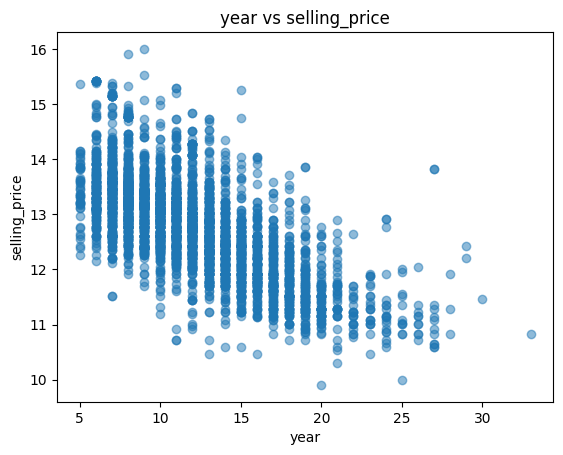

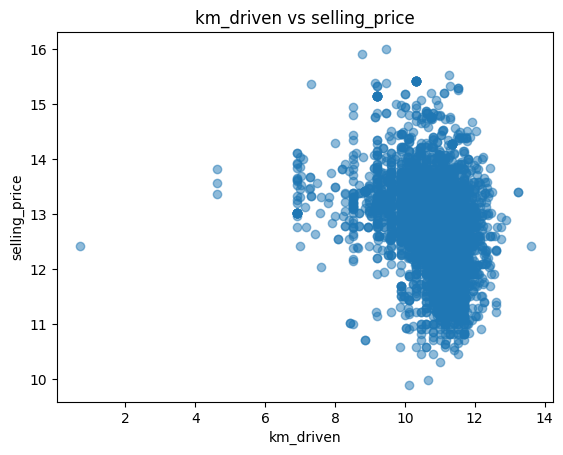

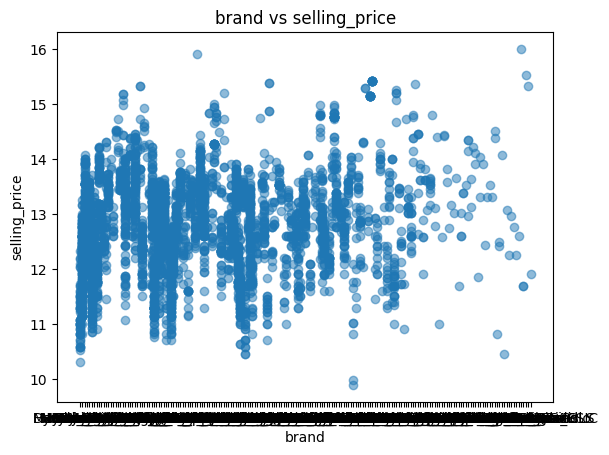

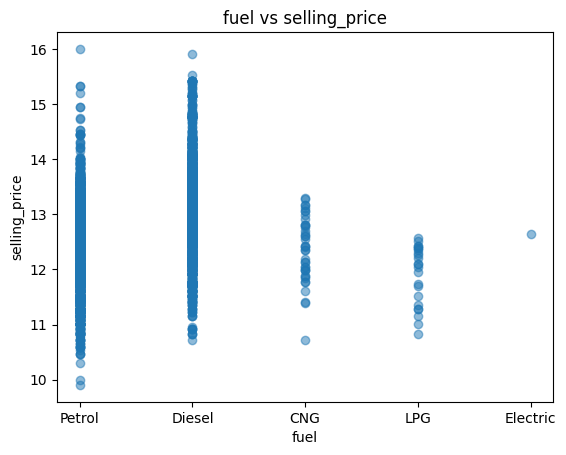

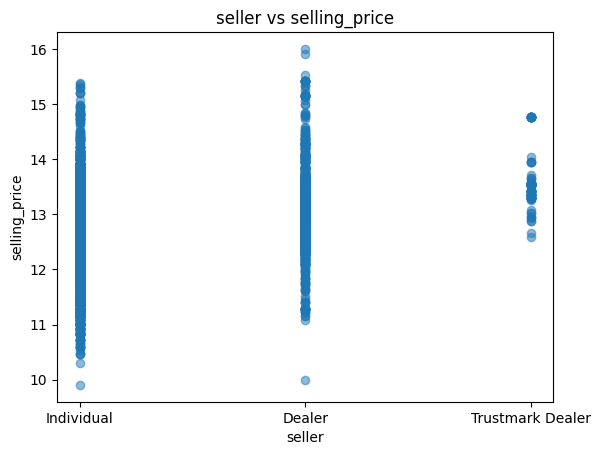

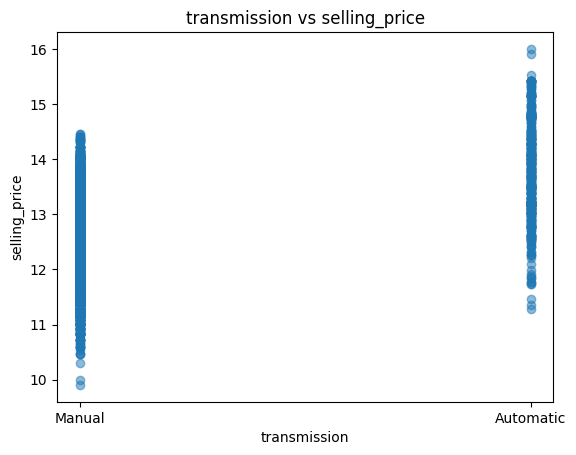

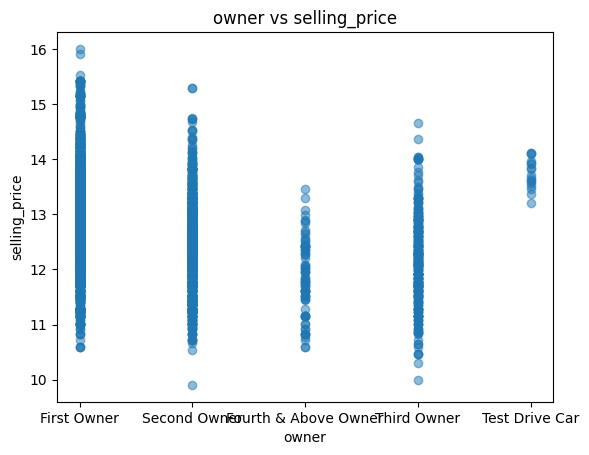

In [10]:
x_axis=[x for x in df.drop(columns='selling_price')]
y_axis=df['selling_price']

for i in x_axis:
    plt.scatter(df[i], y_axis, alpha=0.5)
    plt.xlabel(i)
    plt.ylabel("selling_price")
    plt.title(f"{i} vs selling_price")
    plt.show()

#spliting Data

In [11]:
from sklearn.model_selection import train_test_split

x=df.drop(columns='selling_price')
y=df['selling_price']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [12]:
x_train.head()

,year,km_driven,brand,fuel,seller,transmission,owner
227,8,9.903538,Mahindra_Scorpio,Diesel,Individual,Manual,First Owner
964,7,10.819798,Maruti_Swift,Diesel,Individual,Manual,First Owner
2045,12,10.126671,Maruti_Alto,Petrol,Individual,Manual,Second Owner
1025,14,11.156265,Chevrolet_Beat,Diesel,Individual,Manual,First Owner
4242,8,11.184435,Maruti_Vitara,Diesel,Dealer,Manual,First Owner


#encoding

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
num_transform=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean'))
])
cat_transform=Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])


preprocess=ColumnTransformer(transformers=[
    ('num',num_transform,num_col),
    ('cat',cat_transform,cat_col)
])

#Model parameter

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


# -------------------------------
# Define models + param grids
# -------------------------------
models = {
    "Ridge": {
        "model": Ridge(),
        "params": {"model__alpha": [0.01, 0.1, 1, 10, 100]}
    },
    "Lasso": {
        "model": Lasso(max_iter=5000),
        "params": {"model__alpha": [0.001, 0.01, 0.1, 1, 10]}
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 10],
            "model__min_samples_split": [ 5]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42, n_jobs=-1),
        "params": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.01, 0.1],
            "model__max_depth": [3, 5, 7]
        }
    }
}

# -------------------------------
# Loop through models with GridSearchC



In [15]:
best_models = {}

for name, mp in models.items():
    print(f"\n🔹 Running GridSearchCV for {name}...")

    pipe = Pipeline(steps=[('preprocessor', preprocess),
                           ('model', mp["model"])])

    grid = GridSearchCV(pipe, mp["params"], cv=5, scoring="r2", n_jobs=-1)
    grid.fit(x_train, y_train)

    print(f"✅ Best params for {name}: {grid.best_params_}")
    print(f"📊 Best CV R2: {grid.best_score_:.4f}")

    best_models[name] = grid.best_estimator_



🔹 Running GridSearchCV for Ridge...
✅ Best params for Ridge: {'model__alpha': 0.1}
📊 Best CV R2: 0.8900

🔹 Running GridSearchCV for Lasso...
✅ Best params for Lasso: {'model__alpha': 0.001}
📊 Best CV R2: 0.8363

🔹 Running GridSearchCV for RandomForest...
✅ Best params for RandomForest: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}
📊 Best CV R2: 0.8575

🔹 Running GridSearchCV for XGBoost...
✅ Best params for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
📊 Best CV R2: 0.8692


In [16]:
from sklearn.ensemble import VotingRegressor

ensemble=VotingRegressor(estimators=[
    ('ridge',best_models['Ridge']),
    ('lasso',best_models['Lasso']),
    ('randomforest',best_models['RandomForest']),
    ('XGBoost',best_models['XGBoost'])

])


ensemble.fit(x_train,y_train)

VotingRegressor(estimators=[('ridge',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               ['year',
                                                                                'km_driven']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['brand',
                                                                                'fuel',
                                                                                'seller',
                                                                                'transmission',
                                                                                'owner'...
                                                           feature_weights=None,
                                                           gamma=None,
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=0.1,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=7,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=200,
                                                           n_jobs=-1,
                                                           num_parallel_tree=None, ...))]))])

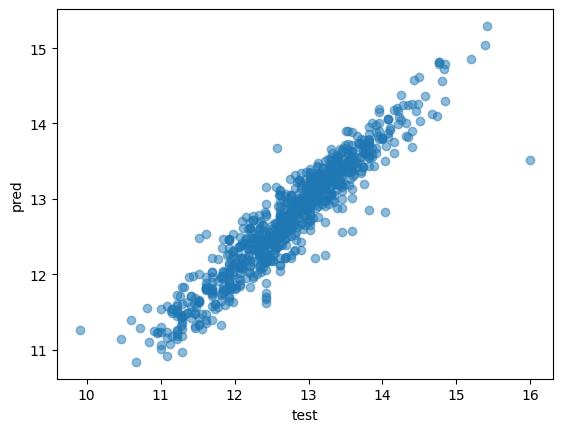

In [17]:
y_pred=ensemble.predict(x_test)

plt.scatter(y_test,y_pred,alpha=0.5)
plt.xlabel("test")
plt.ylabel('pred')
plt.show()

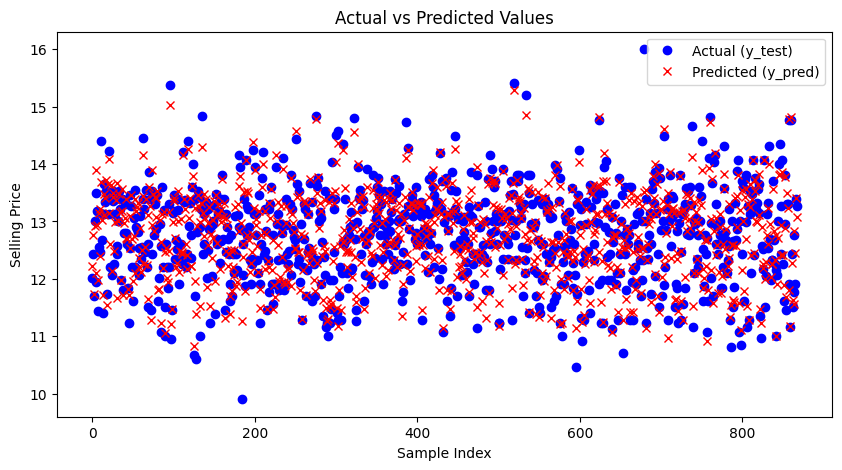

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# Plot actual values
plt.plot(y_test.values, label='Actual (y_test)', color='blue', marker='o', linestyle='')

# Plot predicted values
plt.plot(y_pred, label='Predicted (y_pred)', color='red', marker='x', linestyle='')

plt.xlabel('Sample Index')
plt.ylabel('Selling Price')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Use predicted values, not y_train
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")


MAE: 0.20
RMSE: 0.28
R2 Score: 0.8880


In [22]:
def inv(x):
  return np.expm1(x)

In [25]:
import pickle
with open ('car_model.pkl','wb') as f:
  pickle.dump(ensemble,f)


In [26]:
def load_model():
    with open('car_model.pkl', 'rb') as file:
        model = pickle.load(file)
    return model

model = load_model()



In [27]:
x_test.head(2)

,year,km_driven,brand,fuel,seller,transmission,owner
3978,15,11.289794,Tata_Manza,Diesel,Individual,Manual,First Owner
1448,6,10.203629,Renault_KWID,Petrol,Individual,Manual,First Owner


In [28]:
x_test.iloc[[1]]

,year,km_driven,brand,fuel,seller,transmission,owner
1448,6,10.203629,Renault_KWID,Petrol,Individual,Manual,First Owner


In [29]:
inv(model.predict(x_test.head(1)))

array([202771.82042334])

#gradio UI

In [30]:
pip install gradio

In [33]:
brand=df['brand'].unique()

In [34]:
import gradio as gr
import pickle
import pandas as pd
import numpy as np

# --- 1. Helper Functions (from your training script) ---
def age(x):
  """Calculates the age of the car."""
  return 2025 - x

def km(x):
  """Applies a log transformation to the kilometers driven."""
  return np.log1p(x)

def inv(x):
  """Reverses the log transformation to get the actual price."""
  return np.expm1(x)

# --- 2. Load Your Trained Model ---
# This line loads the file you uploaded.
with open('carmodel.pkl', 'rb') as file:
    model = pickle.load(file)

# --- 3. Create the Prediction Function ---
def predict_price(year, km_driven, fuel, seller, transmission,owner,brand):
    """Takes user inputs, processes them, and returns the predicted price."""

    # Pre-process the inputs
    car_age = age(year)
    km_log = km(km_driven)

    # Create a DataFrame in the exact format the model expects
    input_data = pd.DataFrame({
        'year': [car_age],
        'km_driven': [km_log],
        'brand': [brand],  # Placeholder for brand feature
        'fuel': [fuel],
        'seller': [seller],
        'transmission': [transmission],
        'owner': [owner]
    })

    # Make a prediction
    predicted_price_log = model.predict(input_data)

    # Inverse transform to get the final price
    final_price = inv(predicted_price_log[0])

    # Format the output for display
    return f"Predicted Selling Price: ₹ {final_price:,.2f}"
brand=df['brand'].unique().tolist()
# --- 4. Define and Launch the Gradio Interface ---
iface = gr.Interface(
    fn=predict_price,
    title="🚗 Used Car Price Predictor",
    description="Enter the car details to get an estimated selling price.",
    inputs=[
        gr.Slider(minimum=2000, maximum=2024, step=1, value=2015, label="Model Year"),
        gr.Number(value=50000, label="Kilometers Driven"),
        gr.Dropdown(['Petrol', 'Diesel', 'CNG', 'LPG', 'Electric'], label="Fuel Type", value="Petrol"),
        gr.Dropdown(['Individual', 'Dealer', 'Trustmark Dealer'], label="Seller Type", value="Individual"),
        gr.Dropdown(['Manual', 'Automatic'], label="Transmission Type", value="Manual"),
        gr.Dropdown(['First Owner', 'Second Owner', 'Third Owner', 'Fourth & Above Owner'], label="Owner", value="First Owner"),
        gr.Dropdown(brand, label="Brand", value="Maruti_800")
    ],
    outputs=gr.Label(label="Prediction Result")
)

# Launch the app! A public URL will be generated.
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d4ab865eaba3acf3e6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
